<a href="https://colab.research.google.com/github/nivalf/Automated-Speech-Recognition/blob/main/Automated_speech_recognition_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Speech Recognition

The aim of this project is to develop a deep learning system to perform automated speech recognition.


## Details

**Data**
**Input data:** Raw speech has been pre-processed into spectrograms of speech ‘images’ (power vs time vs
frequency). This is the input data (Figure 1). The data is split into training and validation sets (Figure 2).

**Output data:** There are 12 word categories (i.e. 12 classes). This is the output data.

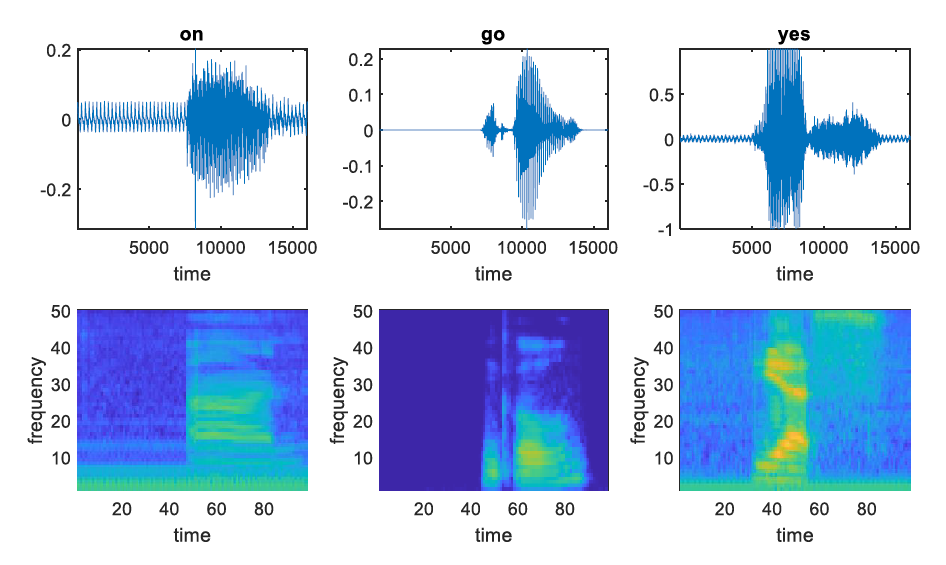

**Figure 1.** Examples of speech waveforms in the time-domain (top) and corresponding speech image
spectrogram that forms the input data (bottom). The spoken word is given in the title and forms the class
label output: ‘on’, ‘go’ and ‘yes’.

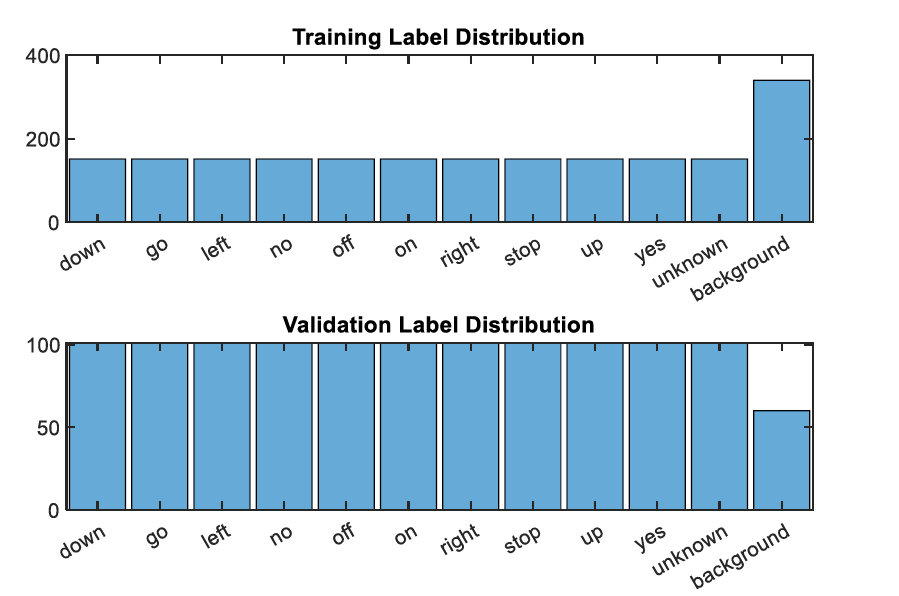


**Figure 2.** The initial training and validation data has the distribution shown in the plots, i.e. 12 words
(therefore 12 classes) and nearly 200 training data pairs per word and 100 validation data pairs per word.


#  <> Pre-process the data

The code does the following:

*   Load the data
*   Creates Keras training and validation datasets
*   Extracts input-output data from the Keras datasets
*   Normalise the image data

## Load the data


  *   Pulls the data in from github
  *   Unzips the data

This is done only if the target folder doesn't exist already. When re-running the entire code, this check ensures that no duplicate folder is created.


In [1]:
import tensorflow as tf
import os.path

path = '/content/speechImageData - Copy/TrainData'

if(not os.path.isdir(path)):
  print('Getting data from github and unzipping...')

  # get the data from github and unzip
  !wget https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
  !unzip -q /content/speechImageData.zip

else:
  print("Unzipped folder already exists! (speechImageData - Copy)")


Unzipped folder already exists! (speechImageData - Copy)


## Pre-process data into training and validation sets, using Keras dataset objects

Note that when the data is unzipped it is stored locally to Google Colab in the content folder and the unzipped folder is called 

'speechImageData - Copy'

and it contains: 

the training data in the folder TrainData and 

the validation in the folder ValData

There are 12 classes of different spoken words and the spectrograms, which form the input image data are of size 98x50 pixels.

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/speechImageData - Copy/TrainData', 
    labels='inferred', 
    color_mode="grayscale", 
    label_mode='categorical', 
    batch_size=128, 
    image_size=(98, 50)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/speechImageData - Copy/ValData', 
    labels='inferred', 
    color_mode="grayscale", 
    label_mode='categorical', 
    batch_size=128, 
    image_size=(98, 50)
)

# Save the number of classes
num_classes = len(train_ds.class_names)

Found 2001 files belonging to 12 classes.
Found 1171 files belonging to 12 classes.


## Extract input-output data, which can be useful for plotting confusion matrices etc.

In [3]:
# Extract the  training input images and output class labels
x_train = []
y_train = []
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

print(y_train)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val = tf.concat(x_val, axis=0)
y_val = tf.concat(y_val, axis=0)

print(y_val)



tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(2001, 12), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]], shape=(1171, 12), dtype=float32)


## Normalise the image data

In [4]:
# Divide by 255 to normalise the data

x_train = x_train/255.0
x_val = x_val/255.0

# <> Baseline Model

## 1. Design the model



Note that the network design has two convolutional blocks:

Conv --> Batch norm --> ReLU

and a max pooling layer is used for dimension reduction

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix     
import seaborn as sns      
from keras.models import Sequential                               
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D, Flatten, Softmax      
from keras import optimizers, regularizers 

In [6]:
# number of convolutional filters
num_filters = 32

# define model
model = Sequential(name="Baseline")

model.add(Input(shape=(98,50,1)))

model.add(Flatten())   # DEV: What does this do?

model.add(Dense(num_classes))
model.add(Softmax())

# set the optimization options and compile the model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4900)              0         
                                                                 
 dense (Dense)               (None, 12)                58812     
                                                                 
 softmax (Softmax)           (None, 12)                0         
                                                                 
Total params: 58,812
Trainable params: 58,812
Non-trainable params: 0
_________________________________________________________________


## 2. Model Details

### 2.1. Keras Plot Model

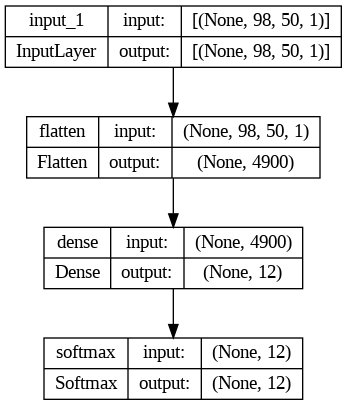

In [9]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### 2.2. Visual Keras

In [20]:
import importlib.util

# Check if package is already installed. Else download
def install_package(name):
  spec = importlib.util.find_spec(name)
  if spec is None:
    print(f"installing {name} module")
    !pip install visualkeras
  else:
    print(f"{name} already installed")

# Install visualkeras & import
install_package('visualkeras')

visualkeras already installed
PIL already installed


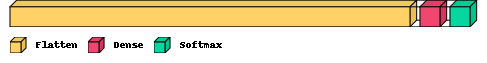

In [22]:
import visualkeras
visualkeras.layered_view(model, legend=True)

## 3. Train the model

This section trains the deep convolutional network using the Adam algorithm.

In [10]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)

Epoch 1/10
29/29 [==============================] - 1s 11ms/step - loss: 2.7610 - accuracy: 0.1867 - val_loss: 2.3692 - val_accuracy: 0.3333
Epoch 2/10
29/29 [==============================] - 0s 5ms/step - loss: 2.2491 - accuracy: 0.3250 - val_loss: 2.3057 - val_accuracy: 0.2786
Epoch 3/10
29/29 [==============================] - 0s 4ms/step - loss: 2.0614 - accuracy: 0.3956 - val_loss: 2.2009 - val_accuracy: 0.3532
Epoch 4/10
29/29 [==============================] - 0s 4ms/step - loss: 1.9612 - accuracy: 0.4500 - val_loss: 2.0658 - val_accuracy: 0.4030
Epoch 5/10
29/29 [==============================] - 0s 4ms/step - loss: 1.8899 - accuracy: 0.4711 - val_loss: 2.1340 - val_accuracy: 0.3930
Epoch 6/10
29/29 [==============================] - 0s 4ms/step - loss: 1.8201 - accuracy: 0.4900 - val_loss: 2.1082 - val_accuracy: 0.3781
Epoch 7/10
29/29 [==============================] - 0s 4ms/step - loss: 1.8465 - accuracy: 0.4928 - val_loss: 2.0443 - val_accuracy: 0.4179
Epoch 8/10
29/29 [=

## 4. Evaluate the model

### 4.1. Plot accuracy and loss over training iterations

Plot accuracy and loss over training epochs (for both training data and validation data) - it is important to monitor convergence of the algorithm via these plots to assess whether the parameter estimation has converged.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


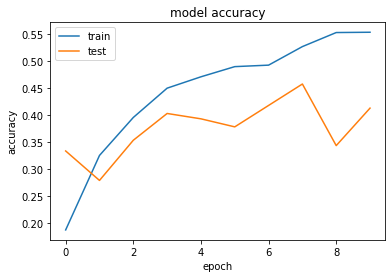

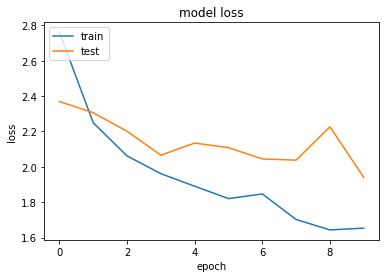

In [11]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("")

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



### 4.2. Print out the accuracy on the Validation Data


In [12]:
# print out the accuracy on independent test data
score = model.evaluate(x_val, y_val, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.3023057281970978


### 4.3. Confusion matrix

Calculate and display the confusion matrix for this problem - the confusion matrix is important to inspect because it gives more insight into classifier performance across all classes than simply inspecting accuracy, which obscures detail.

37/37 [==============================] - 0s 2ms/step


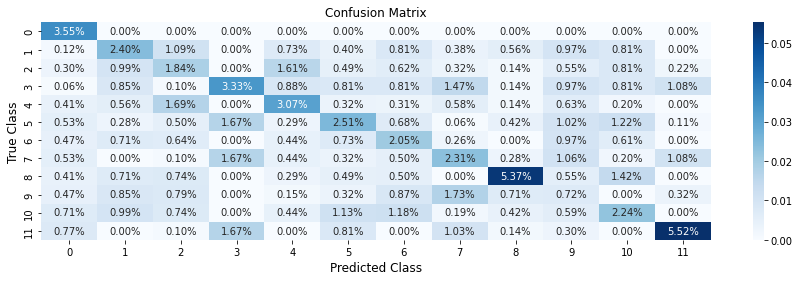

In [13]:
# obtain model predictions and convert softmax outputs 0-1 to integer class label predictions
Yhat = model.predict(x_val)                    # predict model outputs on validation data as softmax outputs of probability of each class
Yhat_integer = np.argmax(Yhat, axis=1)            # obtain the most likely class prediction as the argument of the max softmax output
Y_test_integer = np.argmax(y_val, axis=1)   # obtain the true class as an integer 

# calculate and plot confusion matrix
cm = confusion_matrix(Y_test_integer, Yhat_integer , normalize="pred")    # calculate the confusion matrix
plt.figure(2).set_figwidth(15)                                            # setup new figure
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap="Blues",)          # plot the confusion matrix using the sns package
plt.title("Confusion Matrix", fontsize = 12)                              # title
plt.xlabel("Predicted Class", fontsize = 12)                              # xlabel
plt.ylabel("True Class", fontsize = 12)                                   # ylabel
plt.show()                                                                # show plot